In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile

%matplotlib inline

mean type

In [2]:
# mean_name = 'mean_date_20200815_datatype_n_model_mlp_gan1_seed_0_mean_lr_5e-05_g_lr_0.0001_d_lr_0.0005_mean_hidden_dim_100_gan_type_gan1_gan_hidden_dim_100_batch_32_epoch_1000_noise_100.npy'
# mean_result = np.load(mean_name, allow_pickle=True)

noise type

In [3]:
# noise_name = 'std_date_20200815_datatype_n_model_mlp_gan1_seed_0_mean_lr_5e-05_g_lr_0.0001_d_lr_0.0005_mean_hidden_dim_100_gan_type_gan1_gan_hidden_dim_100_batch_32_epoch_1000_noise_100.npy'
# noise_result = np.load(noise_name, allow_pickle=True)

total type

In [4]:
# # base gan
# total_name = 'total_date__data_n_model_mlp_gan1_seed_0_lr_5e-05_0.0001_0.0005_hidden_dim_100_100_batch_size_32_epoch_1000_200_noise_d_100_sample_num_50.npy'
# # base wgan
# total_name = 'total_date__data_n_model_mlp_wgan_seed_0_lr_5e-05_0.0001_0.0005_hidden_dim_100_100_batch_size_32_epoch_1000_200_noise_d_100_sample_num_50.npy'
# # new wgan
# total_name = 'total_date__data_n_model_mlp_wgan_seed_0_lr_5e-05_0.0005_0.001_hidden_dim_100_200_batch_size_32_epoch_1000_200_noise_d_100_sample_num_50.npy'
# # # base gan
# # total_name = 'total_date__data_n_model_mlp_gan1_seed_0_lr_5e-05_0.0001_0.0005_hidden_dim_100_100_batch_size_32_epoch_1000_200_noise_d_100_sample_num_50.npy'
# # # base gan
# # total_name = 'total_date__data_n_model_mlp_gan1_seed_0_lr_5e-05_0.0001_0.0005_hidden_dim_100_100_batch_size_32_epoch_1000_200_noise_d_100_sample_num_50.npy'





# total_result = np.load(total_name, allow_pickle=True)

TRUE DATA

In [5]:
import torch
from torch.utils.data import DataLoader, TensorDataset

from torchvision import transforms


import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import numpy as np

import matplotlib.pyplot as plt
import math
import sklearn
from sklearn.metrics import r2_score
import os

def get_dataset(name, datatype):
    if name == 'LER_data_20191125.xlsx':
        return SEMI_data(name, datatype, num_input=4, num_output=8, num_in_cycle=10, num_of_cycle=270, num_train=230, num_val=20, num_test=20, x_cols="D:G", y_cols="K:S", header=2)
    elif name == 'LER_data_20191107.xlsx':
        return SEMI_data(name, datatype, num_input=4, num_output=8, num_in_cycle=10, num_of_cycle=185, num_train=150, num_val=15 , num_test=20, x_cols="D:G", y_cols="K:S", header=2)
    elif name == '2020_LER_20200529_V004.xlsx':
        return SEMI_data(name, datatype, num_input=4, num_output=6, num_in_cycle=50, num_of_cycle=72, num_train=50, num_val=10, num_test=12, x_cols="D:G", y_cols="H:P", header=0)
    elif name == '2020_LER_20200804_V006.xlsx':
        return SEMI_data(name, datatype, num_input=4, num_output=6, num_in_cycle=50, num_of_cycle=200, num_train=150, num_val=20, num_test=30, x_cols="B:G", y_cols="H:P", header=0)
        
def load_data(file_path, datatype, num_input, num_output, num_in_cycle, num_of_cycle, x_cols, y_cols, header):  
    """
    
     1) 20191107 기준 : num_input, num_output, num_of_cycle = 185, num_in_cycle=10, header=2, usecols="D:G" 확인 필수
     2) num_input, num_output, num_in_cycle, num_of_cycle 새로 추가함
    
    """
    num_total = num_of_cycle*num_in_cycle
    
    if datatype == 'none':
        data_x = pd.read_excel('./'+file_path, sheet_name='uniformly sampled',usecols=x_cols, nrows=num_total+1, header=header)
        data_y = pd.read_excel('./'+file_path, sheet_name='uniformly sampled', usecols=y_cols, nrows=num_total+1, header=header)
        
        # No one-hot encoding 
        X_all , Y_all = np.zeros((num_total, num_input)), np.zeros((num_total, num_output))
        X_per_cycle, Y_per_cycle = np.zeros((num_of_cycle, num_input)), np.zeros((num_of_cycle, num_output))
        
        # PANDAS TO NUMPY
        # X_per_cycle
        for i in range(num_of_cycle):
            X_per_cycle[i] = data_x[i*num_in_cycle+1:i*num_in_cycle+2].values

        # X_all
        X_all = np.repeat(X_per_cycle,num_in_cycle,axis=0)
        for i in range(X_all.shape[0]):
            print(X_all[i])


        # Y_all
        for i in range(num_total):
            Y_all[i] = data_y[i+1:i+2].values

        # Y_per_cycle
        for i in range(num_of_cycle):
            Y_per_cycle[i] = np.mean(Y_all[i*num_in_cycle:(i+1)*num_in_cycle],axis=0)

    else:
        data_x = pd.read_excel('./'+file_path, sheet_name='Generated DATAs',usecols=x_cols, nrows=num_total+1, header=header)
        data_y = pd.read_excel('./'+file_path, sheet_name='Generated DATAs', usecols=y_cols, nrows=num_total+1, header=header)

        # one-hot encoding (num_input +1)
        X_all , Y_all = np.zeros((num_total, num_input+1)), np.zeros((num_total, num_output))
        X_per_cycle, Y_per_cycle = np.zeros((num_of_cycle, num_input+1)), np.zeros((num_of_cycle, num_output))
 
        # DATA_X DATA_Y preprocessing

        # 1. N, P to 10, 01 (one-hot encoding)
        data_x =pd.get_dummies(data_x, columns=['PNMOS'], dtype=float)

        # 2. Remove unrequired column ( Wfin [nm], alpha )
        # X: Wfin, alpha
        data_x = data_x.drop('Wfin [nm]', axis=1)
        data_x = data_x.drop('alpha', axis=1)

        # Y: IDLO, IDHI, DIBL
        data_y = data_y.drop('IDLO', axis=1)
        data_y = data_y.drop('IDHI', axis=1)
        data_y = data_y.drop('DIBL(mV)', axis=1)
        
        # PANDAS TO NUMPY
        # X_per_cycle
        for i in range(num_of_cycle):    
            #print(data_x[i*num_in_cycle:i*num_in_cycle+1])
            X_per_cycle[i] = data_x[i*num_in_cycle:i*num_in_cycle+1].values

        # X_all
        X_all = np.repeat(X_per_cycle,num_in_cycle,axis=0)

        # DATA_Y preprcoessing

        # Y_all
        for i in range(num_total):
            Y_all[i] = data_y[i:i+1].values

        # Y_per_cycle    
        for i in range(num_of_cycle):
            Y_per_cycle[i] = np.mean(Y_all[i*num_in_cycle:(i+1)*num_in_cycle],axis=0)

        
    print("============ Data load =============")
    print("X data shape: ", X_all.shape, "X per cycle data shape:", X_per_cycle.shape)
    print("Y data shape: ", Y_all.shape, "Y per cycle data shape:", Y_per_cycle.shape)  
    print("any nan in X?: ", np.argwhere(np.isnan(X_all)))
    print("any nan in Y?: ", np.argwhere(np.isnan(Y_all)))
      
    return X_all, Y_all, X_per_cycle, Y_per_cycle

def split_data(x, y, num_train, num_val, num_test):
    
    if len(x) == len(y):
        print("Same number of x data and y data")
        len_total = len(x)
    else:
        print("Different number of x data and y data")
    
    x_train, y_train = x[:num_train], y[:num_train]
    x_val, y_val = x[num_train:num_train+num_val], y[num_train:num_train+num_val]
    x_test, y_test = x[num_train+num_val:], y[num_train+num_val:]
    
    print("============= Data split ==============")
    print("train X: {} train Y: {}".format(x_train.shape, y_train.shape))
    print("val X: {} val Y: {}".format(x_val.shape, y_val.shape))
    print("test X: {} test Y: {}".format(x_test.shape, y_test.shape))

    y_train_mean = np.mean(y_train, axis=0, dtype=np.float32)
    y_train_std = np.std(y_train, axis=0, dtype=np.float32)
    
    x_train_mean = np.mean(x_train, axis=0, dtype=np.float32)
    x_train_std = np.std(x_train, axis=0, dtype=np.float32)
    
    print("x mean, std: ", x_train_mean, x_train_std)
    print("y mean, std: ", y_train_mean, y_train_std)
    
    return x_train, y_train, x_val, y_val, x_test, y_test
    

class Dataset():   
    def __init__(self, name):
        
        self.train_X = None
        self.val_X = None
        self.test_X = None        
        
        self.train_Y = None
        self.val_Y = None
        self.test_Y = None
        
        self.train_X_per_cycle = None
        self.val_X_per_cycle = None
        self.test_X_per_cycle = None
              
        self.train_Y_per_cycle = None
        self.val_Y_per_cycle = None
        self.test_Y_per_cycle = None
        
        self.train_Y_mean= None
        self.val_Y_mean = None
        self.test_Y_mean = None
        
        self.train_Y_noise = None
        self.val_Y_noise = None
        self.test_Y_noise = None

class SEMI_data(Dataset):
    def __init__(self, name, datatype, num_input, num_output, num_in_cycle, num_of_cycle, num_train, num_val, num_test, x_cols, y_cols, header):
        super().__init__(name)
        
        # DATASET with no PN type (2019 datas)
     
        if datatype == 'none':
            X_all, Y_all, X_per_cycle, Y_per_cycle = load_data(name, datatype, num_input, num_output, num_in_cycle, num_of_cycle, x_cols, y_cols, header)
        
            self.train_X, self.train_Y, self.val_X, self.val_Y, self.test_X, self.test_Y = split_data(X_all, Y_all, num_train*num_in_cycle, num_val*num_in_cycle, num_test*num_in_cycle)
            self.train_X_per_cycle, self.train_Y_per_cycle, self.val_X_per_cycle, self.val_Y_per_cycle, self.test_X_per_cycle, self.test_Y_per_cycle = split_data(X_per_cycle, Y_per_cycle, num_train, num_val, num_test) 
            

        # DATASET with PN type (2020 datas)
        
        # use P type
        elif datatype == 'p':
            X_all_temp, Y_all_temp, X_per_cycle_temp, Y_per_cycle_temp = load_data(name, datatype, num_input, num_output, num_in_cycle, num_of_cycle, x_cols, y_cols, header)
            
            X_all = np.empty(num_input+1)
            Y_all= np.empty(num_output)
            
            for i in range(num_of_cycle):
                X_all = np.vstack((X_all, X_all_temp[num_in_cycle*(2*i+1):num_in_cycle*(2*i+1)+num_in_cycle]))
                X_per_cycle = X_per_cycle_temp[1::2]
                Y_all = np.vstack((Y_all, Y_all_temp[num_in_cycle*(2*i+1):num_in_cycle*(2*i+1)+num_in_cycle]))
                Y_per_cycle = Y_per_cycle_temp[1::2]
                
            X_all = X_all[1:]
            Y_all = Y_all[1:]
        
            self.train_X, self.train_Y, self.val_X, self.val_Y, self.test_X, self.test_Y = split_data(X_all, Y_all, num_train*num_in_cycle//2, num_val*num_in_cycle//2, num_test*num_in_cycle//2)
            self.train_X_per_cycle, self.train_Y_per_cycle, self.val_X_per_cycle, self.val_Y_per_cycle, self.test_X_per_cycle, self.test_Y_per_cycle = split_data(X_per_cycle, Y_per_cycle, num_train//2, num_val//2, num_test//2) 
            
        # use N type
        elif datatype == 'n': 
            X_all_temp, Y_all_temp, X_per_cycle_temp, Y_per_cycle_temp = load_data(name, datatype, num_input, num_output, num_in_cycle, num_of_cycle, x_cols, y_cols, header)
            
            X_all = np.empty(num_input+1)
            Y_all= np.empty(num_output)
            
            for i in range(num_of_cycle):
                X_all = np.vstack((X_all, X_all_temp[num_in_cycle*(2*i):num_in_cycle*(2*i)+num_in_cycle]))
                X_per_cycle = X_per_cycle_temp[::2]
                Y_all = np.vstack((Y_all, Y_all_temp[num_in_cycle*(2*i):num_in_cycle*(2*i)+num_in_cycle]))
                Y_per_cycle = Y_per_cycle_temp[::2]
            
            X_all = X_all[1:]
            Y_all = Y_all[1:]                                       

            # print(X_all.shape, Y_all.shape, X_per_cycle.shape, Y_per_cycle.shape)
            
            self.train_X, self.train_Y, self.val_X, self.val_Y, self.test_X, self.test_Y = split_data(X_all, Y_all, num_train*num_in_cycle//2, num_val*num_in_cycle//2, num_test*num_in_cycle//2)
            self.train_X_per_cycle, self.train_Y_per_cycle, self.val_X_per_cycle, self.val_Y_per_cycle, self.test_X_per_cycle, self.test_Y_per_cycle = split_data(X_per_cycle, Y_per_cycle, num_train//2, num_val//2, num_test//2)        
        # use both P, N type
        else:
            
            X_all, Y_all, X_per_cycle, Y_per_cycle = load_data(name, datatype, num_input, num_output, num_in_cycle, num_of_cycle, x_cols, y_cols, header)

            self.train_X, self.train_Y, self.val_X, self.val_Y, self.test_X, self.test_Y = split_data(X_all, Y_all, num_train*num_in_cycle, num_val*num_in_cycle, num_test*num_in_cycle)
            self.train_X_per_cycle, self.train_Y_per_cycle, self.val_X_per_cycle, self.val_Y_per_cycle, self.test_X_per_cycle, self.test_Y_per_cycle = split_data(X_per_cycle, Y_per_cycle, num_train, num_val, num_test)             
        
        # STEP 2: Split data
        
        # OPTIONAL: Split data for Y_mean, Y_noise
        
        self.train_Y_mean = np.repeat(self.train_Y_per_cycle, num_in_cycle, axis=0)
        self.val_Y_mean = np.repeat(self.val_Y_per_cycle, num_in_cycle, axis=0)
        self.test_Y_mean = np.repeat(self.test_Y_per_cycle, num_in_cycle, axis=0)
        
        print("train_Y_mean shape", self.train_Y_mean.shape)
        print("val_Y_mean shape", self.val_Y_mean.shape)
        print("test_Y_mean shape", self.test_Y_mean.shape)
        
        self.train_Y_noise = self.train_Y - self.train_Y_mean
        self.val_Y_noise = self.val_Y - self.val_Y_mean
        self.test_Y_noise = self.test_Y - self.test_Y_mean
        
        print("train_Y_noise shape", self.train_Y_noise.shape)
        print("val_Y_noise shape", self.val_Y_noise.shape)
        print("test_Y_noise shape", self.test_Y_noise.shape) 
        
        
        
from scipy import linalg
def FID_score(generated_samples, real_samples):
    # https://en.wikipedia.org/wiki/Sample_mean_and_covariance
    mu_g = np.mean(generated_samples, axis=0, keepdims=True).T
    mu_r = np.mean(real_samples, axis=0, keepdims=True).T
    cov_g = (generated_samples - np.ones((len(generated_samples),1)).dot(mu_g.T)).T.dot((generated_samples - np.ones((len(generated_samples),1)).dot(mu_g.T)))/(len(generated_samples)-1)
    cov_r = (real_samples - np.ones((len(real_samples),1)).dot(mu_r.T)).T.dot((real_samples - np.ones((len(real_samples),1)).dot(mu_r.T)))/(len(real_samples)-1)

    
    mean_diff = mu_g - mu_r
    cov_prod_sqrt = linalg.sqrtm(cov_g.dot(cov_r))
    
    #numerical instability of linalg.sqrtm
    #https://github.com/mseitzer/pytorch-fid/blob/master/pytorch_fid/fid_score.py
    eps=1e-6
    if not np.isfinite(cov_prod_sqrt).all():
        offset = np.eye(cov_g.shape[0]) * eps
        cov_prod_sqrt = linalg.sqrtm((cov_g + offset).dot(cov_r + offset))

    if np.iscomplexobj(cov_prod_sqrt):
        if not np.allclose(np.diagonal(cov_prod_sqrt).imag, 0, atol=1e-3):
            m = np.max(np.abs(cov_prod_sqrt.imag))
            raise ValueError('Imaginary component {}'.format(m))
        cov_prod_sqrt = cov_prod_sqrt.real
    
    
    FID_score = np.sum(mean_diff**2) + np.trace(cov_g + cov_r -2*cov_prod_sqrt)
    
    
    return FID_score

In [6]:
name = '2020_LER_20200804_V006.xlsx'
datatype = 'n'

dataset = get_dataset(name, datatype)

real = dataset.test_Y
mean_real = dataset.test_Y_mean
noise_real = dataset.test_Y_noise

============ Data load =============
X data shape:  (10000, 5) X per cycle data shape: (200, 5)
Y data shape:  (10000, 6) Y per cycle data shape: (200, 6)
any nan in X?:  []
any nan in Y?:  [[4450    0]
 [4450    1]
 [4450    2]
 ...
 [9999    3]
 [9999    4]
 [9999    5]]
Same number of x data and y data
============= Data split ==============
train X: (3750, 5) train Y: (3750, 6)
val X: (500, 5) val Y: (500, 6)
test X: (750, 5) test Y: (750, 6)
x mean, std:  [  0.41795138  51.47284    122.14498      1.           0.        ] [ 0.20212363 27.062914   51.619465    0.          0.        ]
y mean, std:  [2.2068280e-12 4.1595627e-05 1.6299980e-05 3.4310421e-01 3.5104963e-01
 6.1669216e+01] [7.7416974e-13 2.1877843e-06 8.3063077e-07 7.4241282e-03 6.6630146e-03
 3.2903570e-01]
Same number of x data and y data
============= Data split ==============
train X: (75, 5) train Y: (75, 6)
val X: (10, 5) val Y: (10, 6)
test X: (15, 5) test Y: (15, 6)
x mean, std:  [  0.41795373  51.47359    122.1460

In [7]:
# base gan
# total_name = 'total_date__data_n_model_mlp_gan1_seed_0_lr_5e-05_0.0001_0.0005_hidden_dim_100_100_batch_size_32_epoch_1000_200_noise_d_100_sample_num_50.npy'

# # base wgan : 
# total_name = 'total_date__data_n_model_mlp_wgan_seed_0_lr_5e-05_0.0001_0.0005_hidden_dim_100_100_batch_size_32_epoch_1000_200_noise_d_100_sample_num_50.npy'

# # wgan : noise_d 200 #증가별로
# total_name = 'total_date_20200825_data_n_model_mlp_wgan_seed_0_lr_5e-05_0.0001_0.0005_hidden_dim_100_100_batch_size_32_epoch_1000_200_noise_d_200_sample_num_50.npy'

# # wgan : hidden_dim 200 #증가 굳
# total_name = 'total_date_20200825_data_n_model_mlp_wgan_seed_0_lr_5e-05_0.0001_0.0005_hidden_dim_100_200_batch_size_32_epoch_1000_200_noise_d_100_sample_num_50.npy'

# # wgan : d_lr 0.001 #증가별로
# total_name = 'total_date_20200825_data_n_model_mlp_wgan_seed_0_lr_5e-05_0.0001_0.001_hidden_dim_100_100_batch_size_32_epoch_1000_200_noise_d_100_sample_num_50.npy'

# # wgan : g_lr 0.0005 #증가별로
# total_name = 'total_date_20200825_data_n_model_mlp_wgan_seed_0_lr_5e-05_0.0005_0.0005_hidden_dim_100_100_batch_size_32_epoch_1000_200_noise_d_100_sample_num_50.npy'

# # wgan : 배치 128 #증가별로
# total_name = 'total_date_20200825_data_n_model_mlp_wgan_seed_0_lr_5e-05_0.0001_0.0005_hidden_dim_100_100_batch_size_128_epoch_1000_200_noise_d_100_sample_num_50.npy'

# wgan : epoch 400 #증가별로
# total_name = 'total_date_20200825_data_n_model_mlp_wgan_seed_0_lr_5e-05_0.0001_0.0005_hidden_dim_100_100_batch_size_32_epoch_1000_400_noise_d_100_sample_num_50.npy'

# wgan : noise_d 50 #감소 굳
# total_name = 'total_date_20200825_data_n_model_mlp_wgan_seed_0_lr_5e-05_0.0001_0.0005_hidden_dim_100_100_batch_size_32_epoch_1000_200_noise_d_50_sample_num_50.npy'

# wgan : hidden_dim 50 #감소 별로
# total_name = 'total_date_20200825_data_n_model_mlp_wgan_seed_0_lr_5e-05_0.0001_0.0005_hidden_dim_100_50_batch_size_32_epoch_1000_200_noise_d_100_sample_num_50.npy'

# wgan : lr_d 0.0001 #감소 별로
# total_name = 'total_date_20200825_data_n_model_mlp_wgan_seed_0_lr_5e-05_0.0001_0.0001_hidden_dim_100_100_batch_size_32_epoch_1000_200_noise_d_100_sample_num_50.npy'

# wgan : lr_g 0.0005 #감소 굳
# total_name = 'total_date_20200825_data_n_model_mlp_wgan_seed_0_lr_5e-05_5e-05_0.0005_hidden_dim_100_100_batch_size_32_epoch_1000_200_noise_d_100_sample_num_50.npy'

# wgan : 좋은거 조합 별로
# total_name = 'total_date_20200825_data_n_model_mlp_wgan_seed_0_lr_5e-05_0.0001_0.0005_hidden_dim_100_100_batch_size_16_epoch_1000_200_noise_d_100_sample_num_50.npy'

# wgan : hidden dim 300 증가
# total_name = 'total_date_20200825_data_n_model_mlp_wgan_seed_0_lr_5e-05_0.0001_0.0005_hidden_dim_100_300_batch_size_32_epoch_1000_200_noise_d_100_sample_num_50.npy'


total_name = 'total_date_20200825_data_n_model_mlp_wgan_seed_0_lr_5e-05_0.0001_0.0005_hidden_dim_100_300_batch_size_32_epoch_1000_200_noise_d_100_sample_num_50.npy'

total_result = np.load(total_name, allow_pickle=True)

In [8]:
print(total_result)
# FID_score(total_result, real)

[[1.25078989e-12 4.01595510e-05 1.59845712e-05 3.60250169e-01
  3.63488641e-01 6.09275984e+01]
 [2.01879590e-12 4.15775711e-05 1.68442575e-05 3.46774723e-01
  3.51760122e-01 6.15547360e+01]
 [1.90159187e-12 4.14347006e-05 1.70143812e-05 3.50020992e-01
  3.53097595e-01 6.13880129e+01]
 ...
 [1.58711412e-12 3.87202315e-05 1.59915952e-05 3.56184547e-01
  3.63191511e-01 6.12215452e+01]
 [2.30425611e-12 3.98162119e-05 1.71588483e-05 3.43035171e-01
  3.51863383e-01 6.17832628e+01]
 [2.38052413e-12 3.98440390e-05 1.71597521e-05 3.42738237e-01
  3.52052278e-01 6.18131856e+01]]


In [9]:
# # for i in range(len(mean_real)):
# #    print(mean_real[i])

# for j in range(len(real)):
#     print(real)

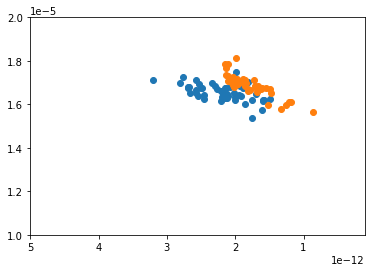

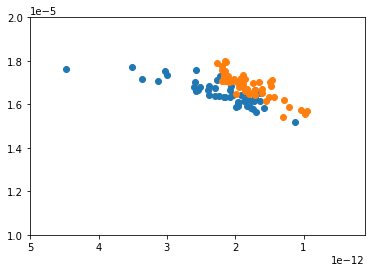

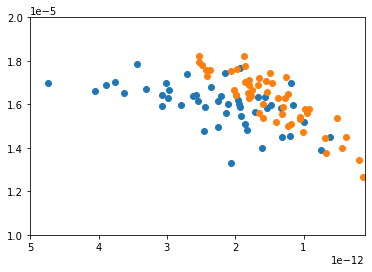

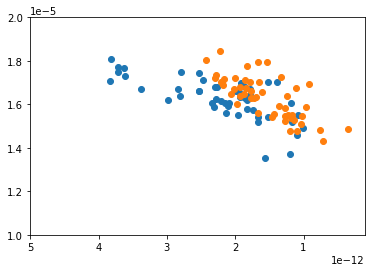

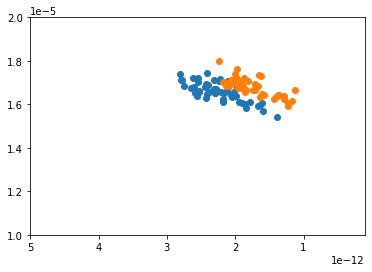

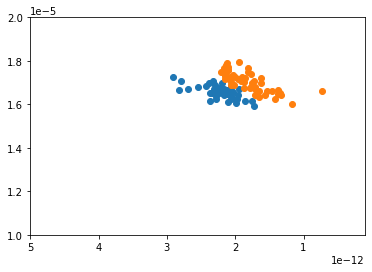

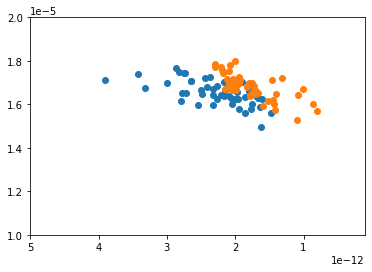

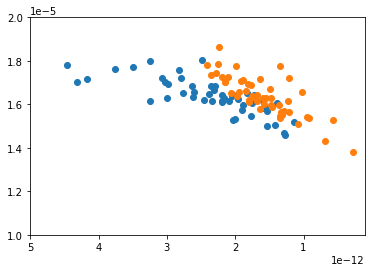

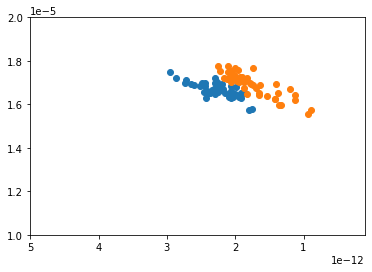

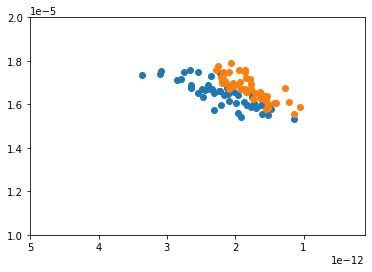

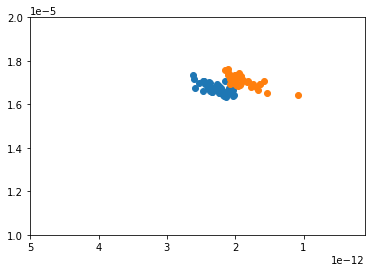

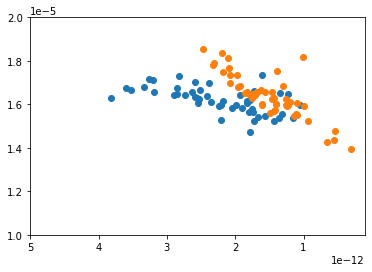

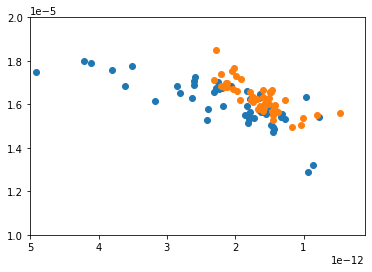

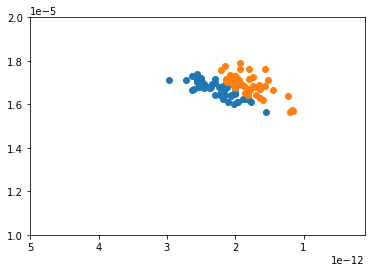

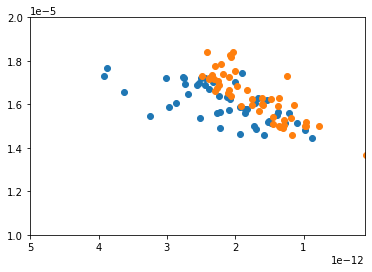

In [10]:
sample_num = 50

factor = sample_num // 50
for idx in range(15):
    start = 50 * idx
    end = 50 * (idx+1)
    plt.scatter(real[start*factor:end*factor,0],real[start*factor:end*factor,2])
    plt.scatter(total_result[start*factor:end*factor,0],total_result[start*factor:end*factor,2])
    plt.xlim(5e-12, 1e-13)
    plt.ylim(1e-5, 2e-5)
    plt.show()

In [11]:
total_result

array([[1.25078989e-12, 4.01595510e-05, 1.59845712e-05, 3.60250169e-01,
        3.63488641e-01, 6.09275984e+01],
       [2.01879590e-12, 4.15775711e-05, 1.68442575e-05, 3.46774723e-01,
        3.51760122e-01, 6.15547360e+01],
       [1.90159187e-12, 4.14347006e-05, 1.70143812e-05, 3.50020992e-01,
        3.53097595e-01, 6.13880129e+01],
       ...,
       [1.58711412e-12, 3.87202315e-05, 1.59915952e-05, 3.56184547e-01,
        3.63191511e-01, 6.12215452e+01],
       [2.30425611e-12, 3.98162119e-05, 1.71588483e-05, 3.43035171e-01,
        3.51863383e-01, 6.17832628e+01],
       [2.38052413e-12, 3.98440390e-05, 1.71597521e-05, 3.42738237e-01,
        3.52052278e-01, 6.18131856e+01]])